<a href="https://colab.research.google.com/github/nehatarey/build-with-llms/blob/main/Neha_%F0%9F%97%A3%EF%B8%8FQuestionMyDocs%F0%9F%93%84_with_LangChain_(OpenAI_Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leveraging LangChain to Build a More Complex Document Querying Application

Now that we have some of the basics of LangChain under our belt - let's build a "full-suite" application.

We'll be working off of this diagram for the following exercise as a template to create our application!

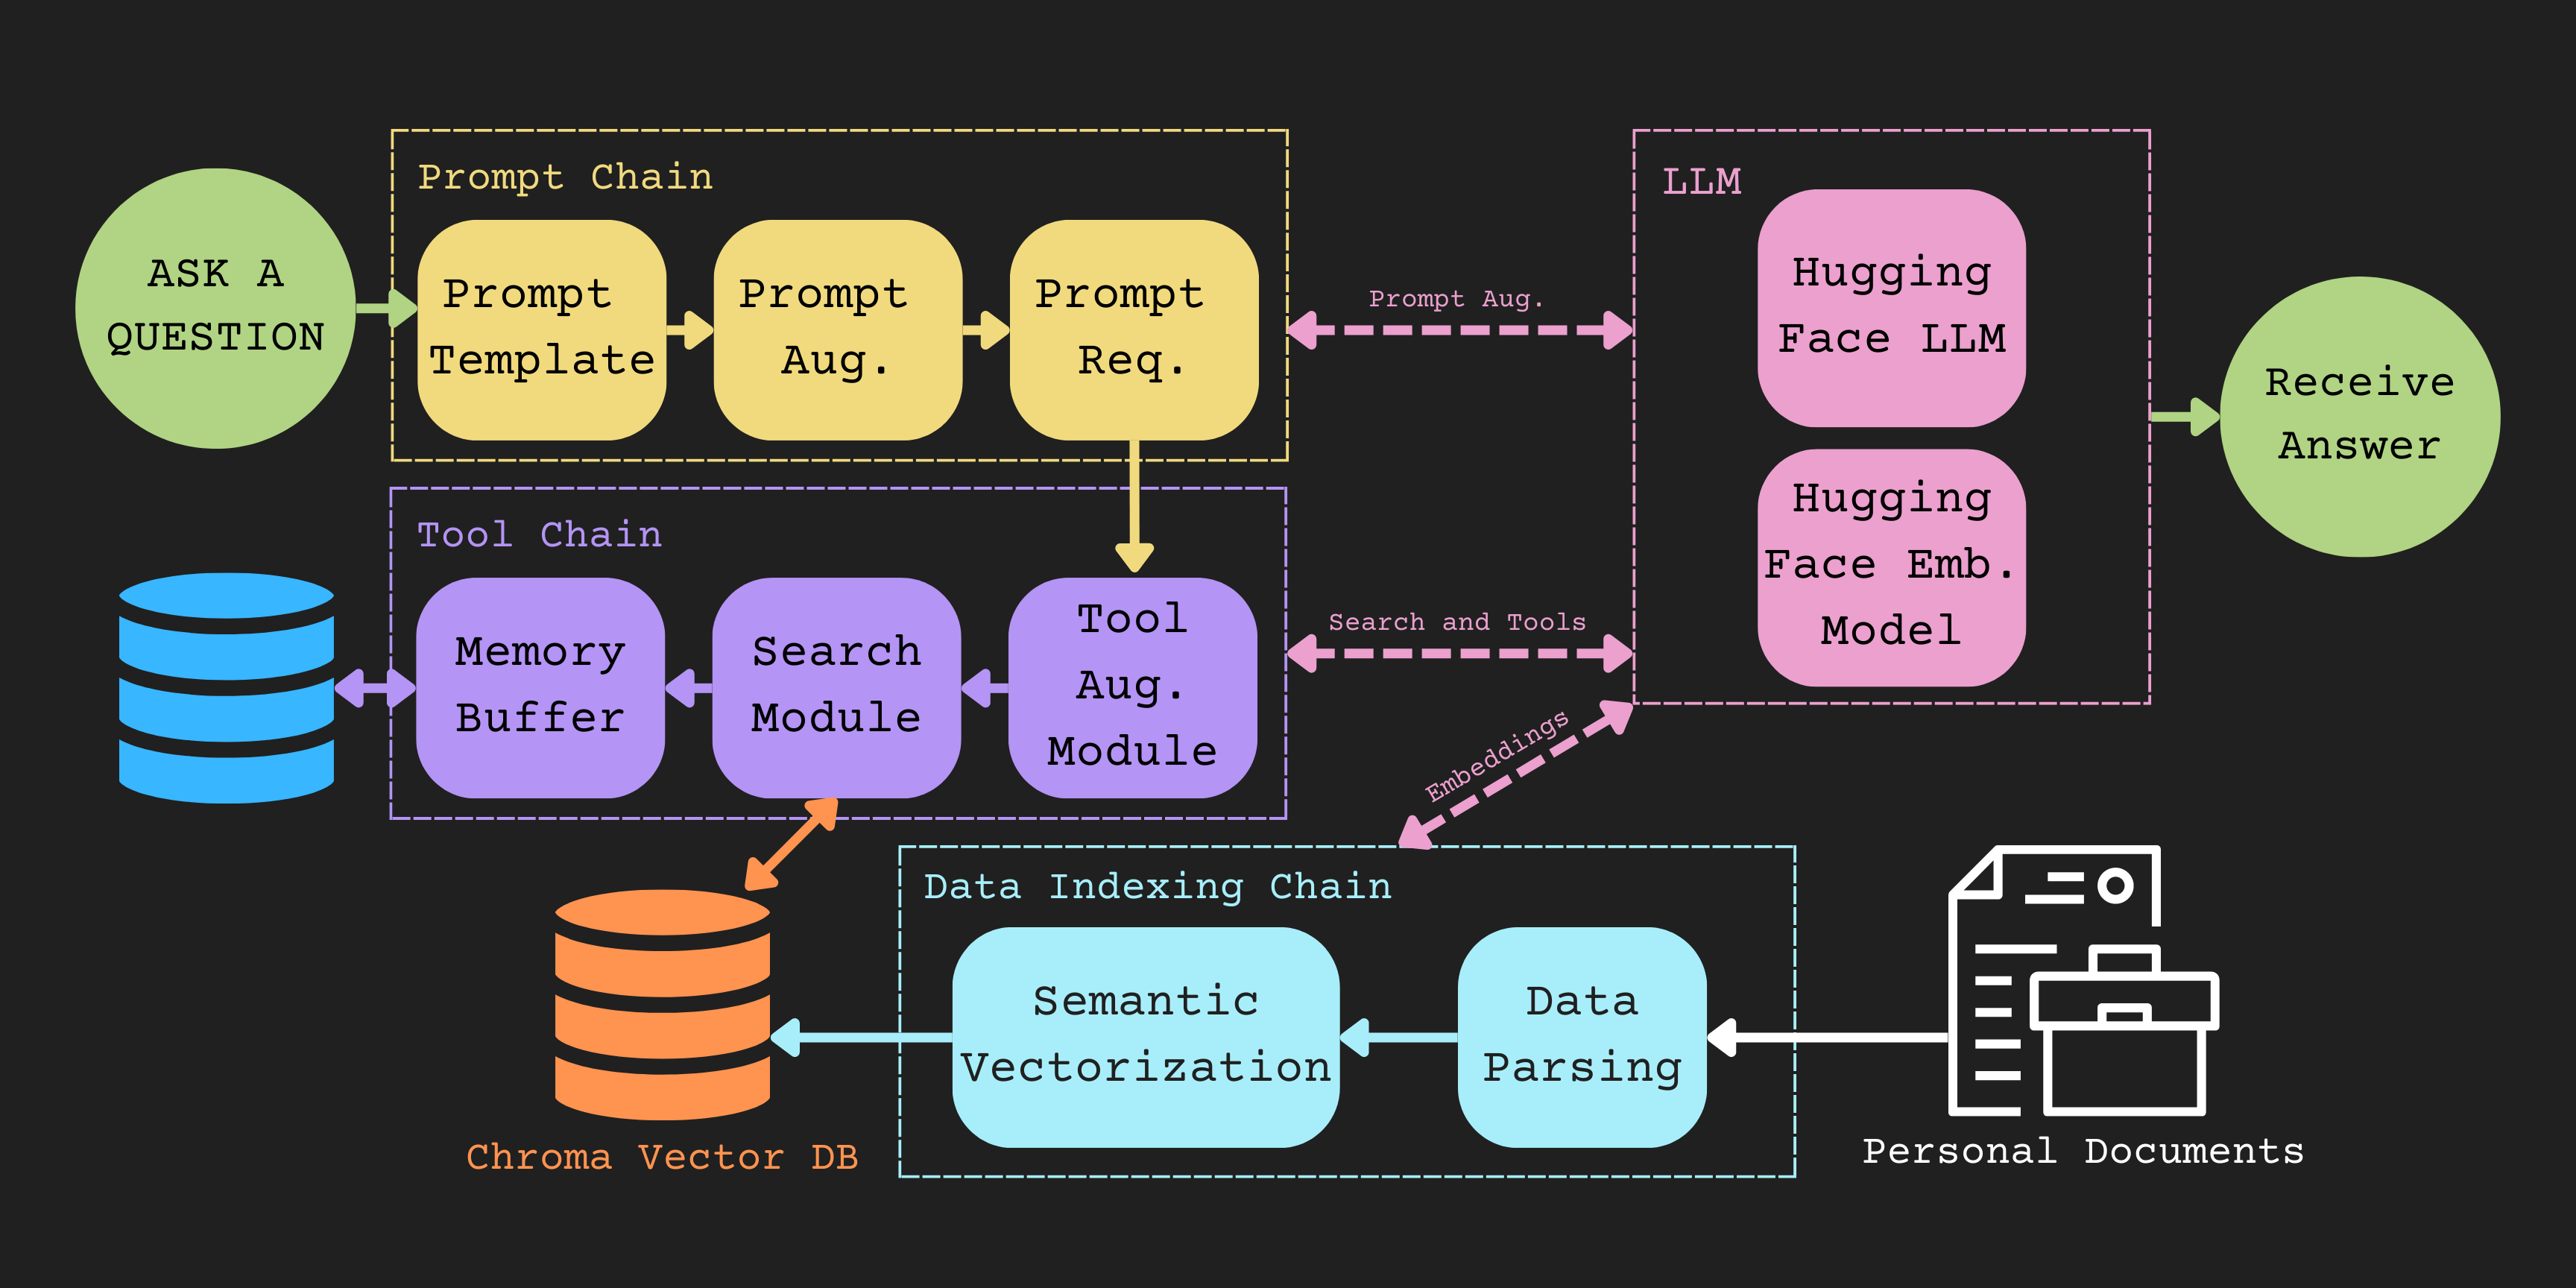

In [1]:
!pip install openai langchain -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.3 MB/s eta 0:00:00


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

### Loading Source Data

We'll be focusing on this section of the diagram for our data.

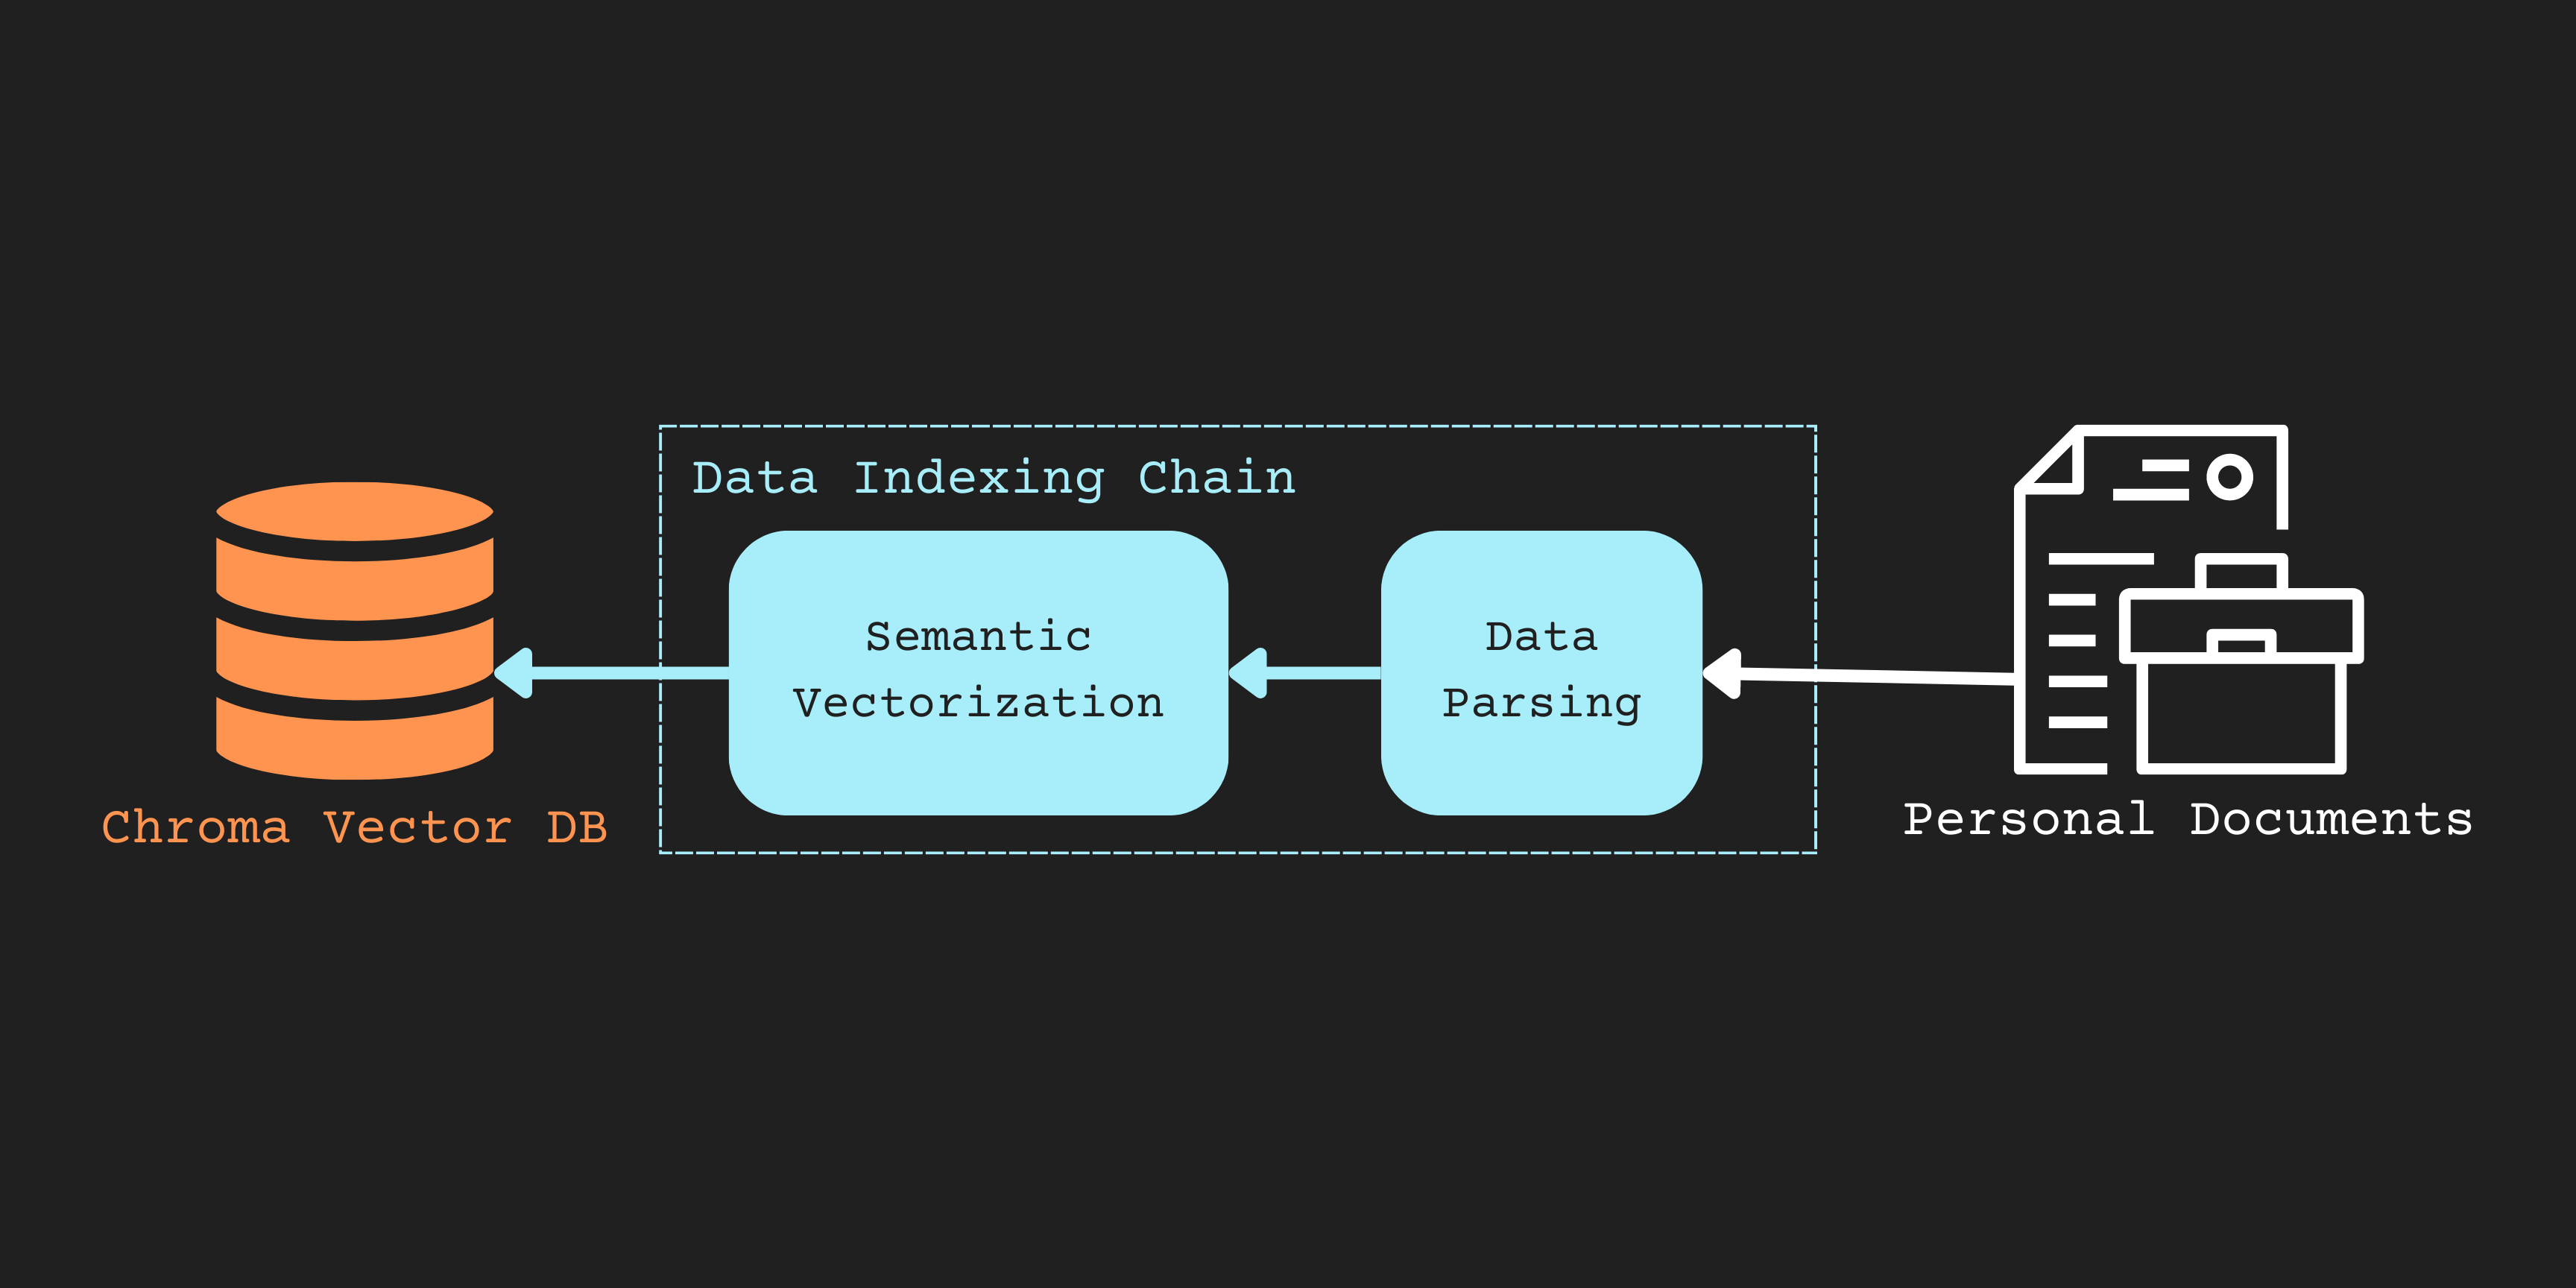

In order to get started, we'll first need a number of documents that we want to collect and manage. 

We'll start with a number of HTML documents provided by [TheMITTech/shakespeare](https://github.com/TheMITTech/shakespeare).

Let's clone that repository to get started!

In [3]:
#!git clone https://github.com/TheMITTech/shakespeare

Let's collect all the HTML documents into a single directory.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%pwd

'/content'

While we'll be using this collection of HTML documents for the remainder of this example - you could use any collection of data that you wanted!

Have a look at [this link](https://python.langchain.com/en/latest/modules/indexes/document_loaders.html) to see the full number of `DocumentLoader`s available.

Now that we have our documents downloaded, let's load them with a combination of `DirectoryLoader` and `BSHTMLLoader`, which is the BeautifulSoup4 powered `HTMLLoader`. We're using this to give us a bit more metadata for our documents.

In [6]:
# install dependencies
!pip install beautifulsoup4 -q

In [7]:
# Fix the file encoding problems
# import os
# import shutil

# source_dir = './drive/MyDrive/Colab_Notebooks/ted_lasso/other_type'
# target_dir = './drive/MyDrive/Colab_Notebooks/ted_lasso/encoding'

# # Create the target directory if it doesn't exist
# os.makedirs(target_dir, exist_ok=True)

# for filename in os.listdir(source_dir):
#     if filename.endswith('.html'):
#         source_path = os.path.join(source_dir, filename)
#         target_path = os.path.join(target_dir, filename)
        
#         with open(source_path, 'rb') as source_file:
#             raw_data = source_file.read()
#             try:
#                 html_content = raw_data.decode('utf-8')
#             except UnicodeDecodeError:
#                 # Handle the error by skipping or replacing problematic characters
#                 html_content = raw_data.decode('utf-8', errors='replace')

#         with open(target_path, 'w', encoding='utf-8') as target_file:
#             target_file.write(html_content)

#         print(f"Copied {filename} successfully.")

# print("Copy operation completed.")



In [8]:

from langchain.document_loaders import BSHTMLLoader, DirectoryLoader
text_loader_kwargs={'autodetect_encoding': True}
directory = './drive/MyDrive/Colab_Notebooks/ted_lasso/encoding'
bshtml_dir_loader = DirectoryLoader(directory, loader_cls=BSHTMLLoader)#, loader_kwargs=text_loader_kwargs)

data = bshtml_dir_loader.load()
len(data)

10

Now that we have our data loaded (with additional metadata thanks to the `BSHTMLLoader`), we can move onto splitting those documents into appropriately sized pieces!

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 20,
    length_function = len,
)

documents = text_splitter.split_documents(data)

Now that we have our documents split - we need to convert them into embeddings!

First up, we'll set-up our OpenAI API key!

In [10]:
import os 

os.environ["OPENAI_API_KEY"] = ""

In [11]:
from langchain.embeddings.openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

Now we can embed our chunked documents into a ChromaVectorDB!

We are going to be going through the example of persisting this particular DB - but we won't be leveraging the persisted version. 

For the example, we just want to showcase how you would persist this particular VectorDB.

You'll notice that there is some GPU usage during this process - since we're leveraging Sentence Transformers to do our embeddings. 

It will also take some time, for that same reason.

In [12]:
# we'll need a few dependencies before we can do this
!pip install chromadb tiktoken -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938.6/938.6 kB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 108.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.3 MB/

In [13]:
from langchain.vectorstores import Chroma

persist_directory = "vector_db"

vectordb = Chroma.from_documents(documents=documents, embedding=embeddings, persist_directory=persist_directory)

Now we can persist our Chroma vector store - and then show an example of how you would load that persisted vector store.

In [14]:
vectordb.persist()
vectordb = None

As you can see when you run the following cell - loaded the persisted vectore store is *much* quicker than reinstantiating it - and that is the benefit of `persist_directory`!

In [15]:
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

Now that we have our docs set-up - we're ready to progress to the next part of the LangChain applciation puzzle!

### Tool Chain

We'll be looking to leverage the entire LangChain suite combined with OpenAI to build a full application - with memory and all!

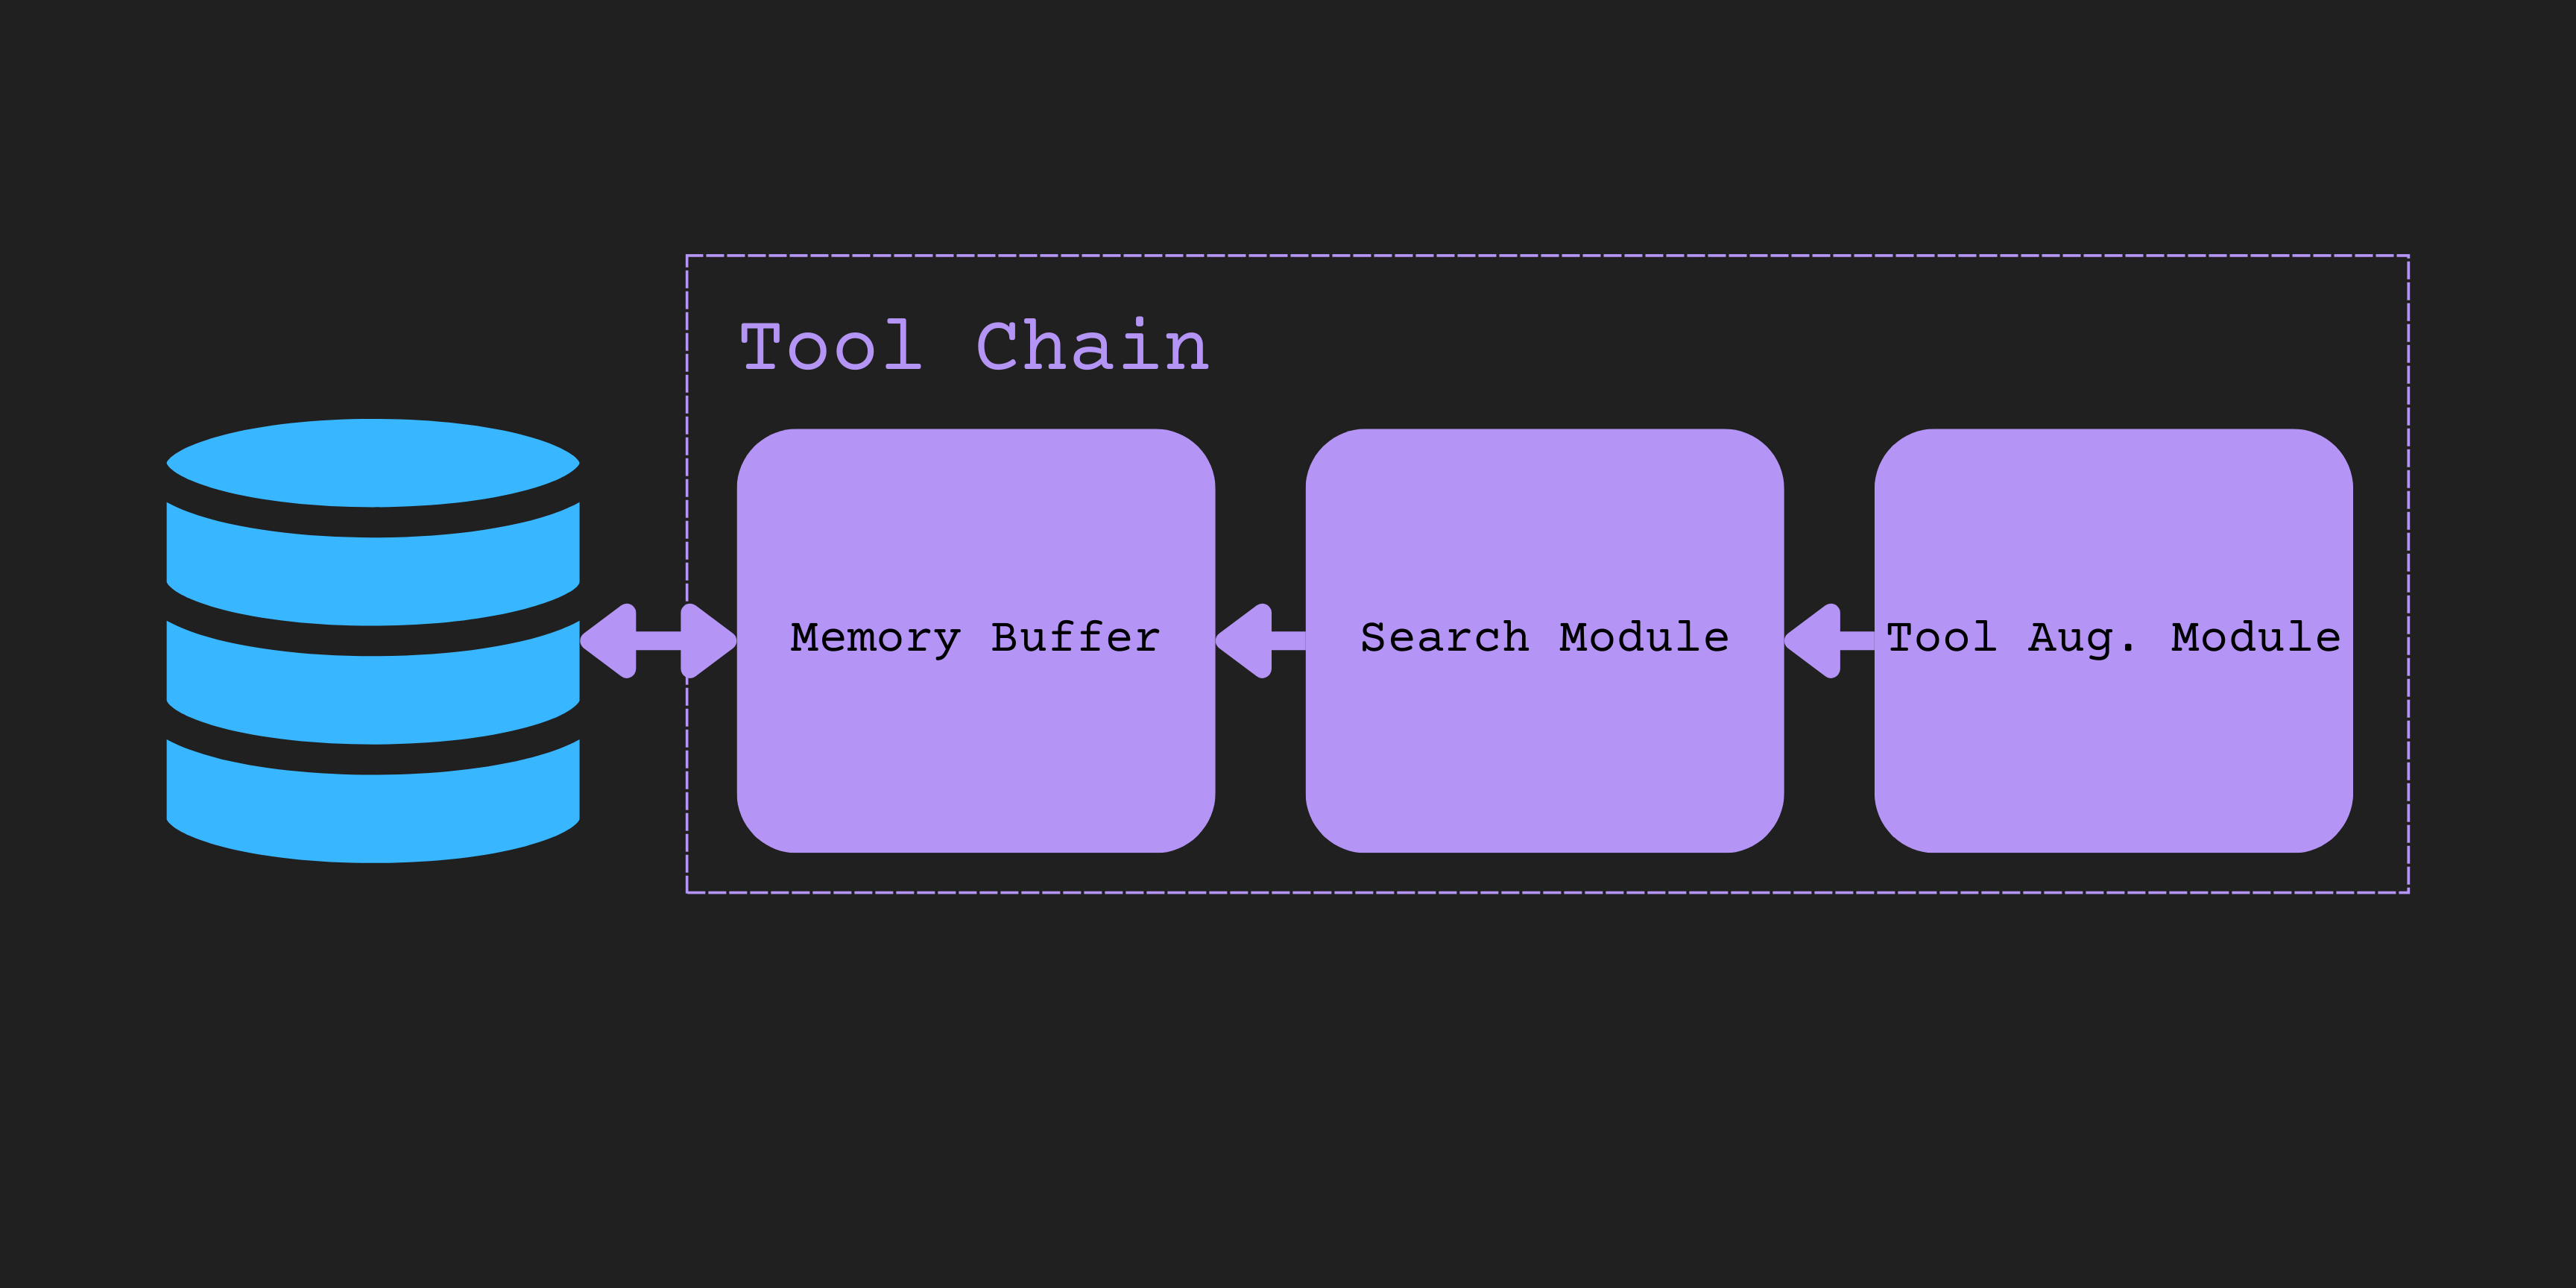


First up, let's load our model!

In [16]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(temperature=1, model="gpt-3.5-turbo")

Now let's set up our document vector store as a Retriever tool so we can leverage it in our chain!

In [17]:
doc_retriever = vectordb.as_retriever()

With that set-up, we're good to set-up our RetrievalQA chain and leverage all the documents we have in our Vector DB!

In [18]:
from langchain.chains import RetrievalQA

ted_lasso_qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=doc_retriever)

Let's test it out by itself!

In [19]:
ted_lasso_qa.run("Which team is Ted coaching?")

'Ted is coaching the Richmond team.'

In [20]:
ted_lasso_qa.run("Who are the main characters")

'The main characters are Ted, Beard, Roy, Higgins, Jamie, Keeley, and Rebecca.'

Now, let's set-up a search tool leveraging SERP API!

You can find the process to set this up [here](https://serpapi.com/)

In [21]:
!pip install google-search-results -q

  Preparing metadata (setup.py) ... done


In [22]:
os.environ["SERPAPI_API_KEY"] = ""

In [23]:
from langchain.utilities import SerpAPIWrapper

search = SerpAPIWrapper()

Now we can combine those 

In [25]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.tools import BaseTool
from langchain.llms import OpenAI
from langchain import LLMMathChain, SerpAPIWrapper

tools = [
    Tool(
        name = "Ted Lasso QA System",
        func=ted_lasso_qa.run,
        description="useful for when you need to answer questions about Ted Lasso series. Input should be a fully formed question."
    ),
    Tool(
        name = "SERP API Search",
        func=search.run,
        description="useful for when you need to answer questions about ruff (a python linter). Input should be a fully formed question."
    ),
]

In [26]:
agent = initialize_agent(tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)

In [27]:
agent.run("What is the name of Ted's assistant coach?")



> Entering new AgentExecutor chain...
I need to use the Ted Lasso QA System since this question is related to the show.
Action: Ted Lasso QA System
Action Input: "What is the name of Ted's assistant coach?"
Observation: Nate is the name of Ted's assistant coach.
Thought:Great, I have the answer to the question.
Final Answer: Nate is the name of Ted's assistant coach.

> Finished chain.


"Nate is the name of Ted's assistant coach."

Now, let's add some memory to our application!

In [28]:
from langchain.memory import ConversationBufferMemory, ReadOnlySharedMemory

memory = ConversationBufferMemory(memory_key="chat_history")
readonlymemory = ReadOnlySharedMemory(memory=memory)

In order to let our Tools leverage the memory - we'll want to add the ability to read the memory to their chains!

In [29]:
ted_lasso_qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=doc_retriever, memory=readonlymemory)

Now we can re-create our Tools list - this time using the memory capable version of the `ted_lasso_qa` chain!

In [30]:
tools = [
    Tool(
        name = "Ted Lasso QA System",
        func=ted_lasso_qa.run,
        description="useful for when you need to answer questions about Ted Lasso season 1. Input should be a fully formed question."
    ),
    Tool(
        name = "SERP API Search",
        func=search.run,
        description="useful for when you need to answer questions about ruff (a python linter). Input should be a fully formed question."
    ),
]

Let's now add some of the prompt pieces so our agent can respond exactly as we expect!

In [31]:
from langchain.agents import ZeroShotAgent, Tool, AgentExecutor

prefix = """Have a conversation with a human, answering the following questions as best you can. You have access to the following tools:"""
suffix = """Begin!"

{chat_history}
Question: {input}
{agent_scratchpad}"""

prompt = ZeroShotAgent.create_prompt(
    tools, 
    prefix=prefix, 
    suffix=suffix, 
    input_variables=["input", "chat_history", "agent_scratchpad"]
)

Now let's add this prompt template to our OpenAI LLM!

In [32]:
from langchain import OpenAI, LLMChain, PromptTemplate

llm_chain = LLMChain(llm=llm, prompt=prompt)

Now we can set up our final agent!

In [33]:
agent = ZeroShotAgent(llm_chain=llm_chain, tools=tools, verbose=True)
agent_chain = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True, memory=memory)

Let's test this out!

In [34]:
agent_chain.run(input="Who is Ted's boss?")



> Entering new AgentExecutor chain...
Thought: Hmm, this seems like a question about Ted Lasso season 1. I should use the Shakespeare QA System.
Action: Shakespeare QA System
Action Input: "Who is Ted Lasso's boss?"
Observation: Ted Lasso's boss is Rebecca Welton.
Thought:Great, now I know who Ted's boss is. Let me see if I can answer a question about ruff.
Action: SERP API Search
Action Input: "What is ruff and how does it work?"


Observation: In trick-taking games, to ruff means to play a trump card to a trick According to the rules of most games, a player must have no cards left in the suit led ...
Thought:

Oops, I didn't get the right results with that search. Let me try again.
Action: SERP API Search
Action Input: "What is ruff Python linter?"


Observation: Ruff is a newly released open source linter for Python code written in Rust. Its main draw for Python developers is its fast speed and performance compared to other, commonly used solutions. The creator, Charlie Marsh, wrote in a Tweet: “Python tooling could be much, much faster.
Thought:

Great, now I know what ruff is and how it works with Python. I can confidently answer any questions about it.
Final Answer: Ted Lasso's boss is Rebecca Welton and ruff is a fast and performance-driven open source linter for Python code written in Rust.

> Finished chain.


"Ted Lasso's boss is Rebecca Welton and ruff is a fast and performance-driven open source linter for Python code written in Rust."

In [35]:
agent_chain.run(input="Who was her husband?")



> Entering new AgentExecutor chain...
Thought: I need to figure out who Rebecca Welton's husband is.
Action: Shakespeare QA System
Action Input: "Who is Rebecca Welton's husband in Ted Lasso season 1?"
Observation: Rebecca Welton's husband is named Rupert in Ted Lasso season 1.
Thought:That didn't answer my question about Rebecca Welton's husband. Let me try a different tool.
Action: SERP API Search
Action Input: "Who is Rebecca Welton's husband in Ted Lasso?"


Observation: Rupert Mannion
Thought:

Based on my previous search results, it looks like Rupert may have changed his last name to Mannion. I need to confirm this.
Action: SERP API Search
Action Input: "What is the last name of Rebecca Welton's husband in Ted Lasso?"


Observation: Who is Bex in 'Ted Lasso'? Actor Keeley Hazell plays Bex, the girlfriend and later wife of Rupert Mannion, Rebecca Welton's ex-husband.
Thought:

Okay, it seems that Rupert Mannion is also known as Rupert Welton and he was previously married to Rebecca Welton in Ted Lasso season 1. 
Final Answer: Rebecca Welton's husband in Ted Lasso season 1 is Rupert Welton (aka Rupert Mannion).

> Finished chain.


"Rebecca Welton's husband in Ted Lasso season 1 is Rupert Welton (aka Rupert Mannion)."

In [36]:
agent_chain.run(input="Did she stay good through the season?")



> Entering new AgentExecutor chain...


Thought: This question is related to Ted Lasso season 1, so I should use the Shakespeare QA System.
Action: Shakespeare QA System
Action Input: "Did Rebecca Welton remain a good character throughout Ted Lasso season 1?"


Observation: Rebecca Welton's character undergoes development throughout Ted Lasso season 1, and she certainly has her flaws and moments of questionable behavior. However, whether or not she remains a "good" character is up for interpretation and may depend on individual opinions.
Thought:

I now know the final answer.
Final Answer: It is debatable whether or not Rebecca Welton remained a good character throughout Ted Lasso season 1.

> Finished chain.


'It is debatable whether or not Rebecca Welton remained a good character throughout Ted Lasso season 1.'

### Conclusion

Here we have it! 

A system capable of querying over multiple documents - all without every needing to hit an external API!